In [2]:
import pandas as pd
import numpy as np
import plotnine as p9
import re
data = pd.read_csv('techscene.csv')

# Data cleaning

## Normalizing job titles

In order to make cleaning and analysis easier, we replace all uppercase letters in the data with lowercase. We also remove some instances of superfluous information from job titles, such as strings like "(m/f/d)" or "SEB | Tallinn".

In [3]:
for column in data.columns:
  data[column]=data[column].str.lower()
#job_name
#remove (m/f/d),(m/f/x),| SEB, Tallinn,
data['job_name']=data['job_name'].str.replace('(m/f/d)', '').replace('(m/f/x)','').replace('| SEB, Tallinn','').replace('\"','')

Some of the data from the beginning of the scraping period doesn't include the field `domain`; the value of this field for these listings is `nan`. We can retroactively add these based on the title of the listing.

In [4]:
data[data['domain'].isna()]

,company_name,job_name,job_link,date_added,domain
0,spectrocoin,front-end software engineer,https://careers.spectrocoin.com/position.html?...,2024-03-26 00:00:00,NaN
1,spectrocoin,react native developer,https://careers.spectrocoin.com/position.html?...,2024-03-26 00:00:00,NaN
2,novater solutions,front-end developer,https://novater.com/careers/front-end-developer/,2024-03-26 00:00:00,NaN
3,lhv,front-end-vanemarendaja,https://boards.greenhouse.io/lhv/jobs/7257214002,2024-03-26 00:00:00,NaN
4,qminder,front-end developer,https://apply.workable.com/j/3a16ed0568,2024-03-26 00:00:00,NaN
...,...,...,...,...,...
737,luminor,senior compliance officer (assurance unit),https://luminorbank.teamtailor.com/jobs/354120...,2024-04-02 00:00:00,NaN
738,cybernetica,post-quantum cryptography engineer,https://cyber.teamdash.com/p/job/iqn79wzx/post...,2024-04-02 00:00:00,NaN
739,cybernetica,researcher,https://cyber.teamdash.com/p/job/pagseczx/rese...,2024-04-02 00:00:00,NaN
740,cybernetica,data architect,https://cyber.teamdash.com/p/job/knvredgr/data...,2024-04-02 00:00:00,NaN


In [5]:
replacement_dict={#regex: domain,
  'software engineer|tarkvaraarendaja|systems engineer|test automation engineer|scala engineer|platform engineer|software support engineer': 'software-development',
  'front-end|frontend|react': 'front-end',
  'back-end|backend': 'back-end',
  'android|ios': 'mobile',
  'devops': 'devops-sre',
  'data scientist|data engineer|data architect': 'data-science',
  'full-stack|full stack': 'full-stack',
  'qa engineer|quality engineer|quality assurance':'qa',
  'analyst|monitooringu spetsialist':'analytics',
  'people operations':'hr',
  'content developer|branding|brand manager':'marketing',
  'product owner|compliance officer|projektijuht|team lead|project lead':'management',
  'manager, debt capital markets|business analyst|business intelligence|aml|financial|risk|kindlustus|ärianalüüs|finance developer': 'finance',
  'cyber security|cryptography engineer|soc analyst|küberturvalisus|secops|protection|surveillance': 'cyber-security',
  'ai engineer|machine learning': 'ai-ml',
  'client specialist|sales manager|account manager|account management': 'sales',
  'support engineer|support associate|tugiteenus|helpdesk': 'customer-support'
  }
for index, row in data[data['domain'].isna()].iterrows():#iterate through all listings that have the 'domain' column as 'nan'
  matched=False
  for regex in replacement_dict.keys():
    if not matched and re.search(regex,row['job_name']):#check if any of the regexes in the dictionary match the name of the listing, if they do, add a domain from replacement_dict
      matched=True
      data.loc[index,'domain']=replacement_dict[regex]
    else:
      data.loc[index,'domain']='other'

## Compressing consecutive listings

Currently, our data contains every instance of a listing scraped in a day. For purposes of analysis, it might be helpful to compress the data so that consecutive appearances of one listing get turned into one single entry, with new fields `first_appeared` and `last_appeared`.

In [6]:
"""
Groups data by company name, job name, and job link. 
Sorts the data by date added and creates blocks of consecutive job postings.
"""
#might not work
def get_consecutive_blocks(data):

    data['date_added'] = pd.to_datetime(data['date_added']).dt.date

    # Normalize text for comparison
    data['job_name'] = data['job_name'].str.lower()
    data['company_name'] = data['company_name'].str.lower()

    # Remove exact duplicates
    data = data.drop_duplicates()

    # Create an empty DataFrame with specified columns
    new_data = pd.DataFrame(columns=["company_name", "job_name", "domain", "first_appeared", "last_appeared", "job_link"])

    grouped = data.groupby(["company_name", "job_name", "job_link"])
    
    for (company_name, job_name, job_link), group in grouped:
        group = group.sort_values('date_added')

        start_date = None
        prev_date = None

        # Get domain if exists in the group
        domain = group['domain'].dropna().iloc[0] if not group['domain'].dropna().empty else None

        for current_date in group['date_added']:
            if start_date is None:
                start_date = current_date
                prev_date = current_date
            elif (current_date - prev_date).days > 1:
                # Special case: check only for 2024-09-06
                if (prev_date == pd.to_datetime('2024-09-05').date() and 
                    current_date == pd.to_datetime('2024-09-07').date()):
                    prev_date = current_date  # Assume continuity
                else:
                    # Save current block if gap is not special case
                    new_data = pd.concat([new_data, pd.DataFrame({
                        "company_name": [company_name],
                        "job_name": [job_name],
                        "domain": [domain],
                        "first_appeared": [start_date],
                        "last_appeared": [prev_date],
                        "job_link": [job_link]
                    })], ignore_index=True)
                    start_date = current_date

                start_date = current_date  # Start a new block

            prev_date = current_date

        # Save the last block
        new_data = pd.concat([new_data, pd.DataFrame({
            "company_name": [company_name],
            "job_name": [job_name],
            "domain": [domain],
            "first_appeared": [start_date],
            "last_appeared": [prev_date],
            "job_link": [job_link]
        })], ignore_index=True)

    return new_data

# Example usage:
# data = pd.read_csv('input.csv')
nd = data.copy()
df = get_consecutive_blocks(data)

In [7]:
"""
Groups data by company name, job name, and job link.
Finds the first appearance and last appearance dates.
"""

def process_job_data(data):
    data['date_added'] = pd.to_datetime(data['date_added']).dt.date

    # Create an empty DataFrame with specified columns
    new_data = pd.DataFrame(columns=["company_name", "job_name", "domain", "first_appeared", "last_appeared", "job_link"])
    
    # Group by unique identifying columns
    grouped = data.groupby(["company_name", "job_name", "job_link"])
    
    # Iterate through each unique group
    for (company_name, job_name, job_link), group in grouped:
        # Find the first and last appearance dates
        first_appeared = group['date_added'].min()
        last_appeared = group['date_added'].max()
        

        # Get domain if exists in the group
        domain = group['domain'].dropna().iloc[0] if not group['domain'].dropna().empty else None

        # Create a new row for this unique entry
        new_row = pd.DataFrame({
            "company_name": [company_name],
            "job_name": [job_name],
            "domain": [domain],
            "first_appeared": [first_appeared],
            "last_appeared": [last_appeared],
            "job_link": [job_link]
        })
        
        # Append to new_data
        new_data = pd.concat([new_data, new_row], ignore_index=True)
    
    return new_data

# Example usage
# data = pd.read_csv('your_input_file.csv')  # Load your input data
#nd = data.copy()
#new_data = process_job_data(data)
#new_data.to_csv('new_data3442!!!.csv', index=False)  # Save processed data

In [8]:
"""
Checks if first data has the same links as second data.
"""
def check_links(data, data2):

    links1 = data["job_link"].unique()
    links2 = data2["job_link"].unique()
    for link in links1:
        if link not in links2:
            print(link)

# Parsing levels (junior/mid/senior), length of posting

In [9]:
level_replacement_dict={#regex: domain,
  r'lead': 'lead',
  r'senior|vanem arendaja': 'senior',
  r'intern': 'intern',
  r'junior': 'junior',
  r'head': 'head',
  r'director': 'director'
}
df['level'] = None
for index, row in df[df['level'].isna()].iterrows():
  matched=False
  for regex in level_replacement_dict.keys():
    if not matched and re.search(regex,row['job_name']):#check if any of the regexes in the dictionary match the name of the listing, if they do, add a level from replacement_dict
      matched=True
      df.loc[index,'level']=level_replacement_dict[regex]
  if not matched:
    df.loc[index,'level']='mid/unknown'

df['length'] = df['last_appeared'] - df['first_appeared'] + pd.Timedelta(days=1)
df['length']=df['length'].apply(lambda x : x.days)#convert timedelta to int

# Analyzing listings by time

## Patterns of posting new listings


## Identify listings that have been up for a long time
There are several listings that seem to have been up for hundreds of days.


In [10]:
df.sort_values("length", inplace=True, ascending=False)
df

,company_name,job_name,domain,first_appeared,last_appeared,job_link,level,length
3038,lightyear,kyb compliance operations specialist,other,2024-04-02,2024-08-27,https://careers.lightyear.com/jobs/3624928-kyb...,mid/unknown,148
2389,bolt,"senior/staff ux researcher, ridehailing",other,2024-04-06,2024-08-21,https://careers.bolt.eu/positions/7314800002,senior,138
18,artec design,linkedin,other,2024-04-02,2024-08-12,https://ee.linkedin.com/company/artec-design-ee,mid/unknown,133
15,artec design,facebook,other,2024-04-02,2024-08-12,https://www.facebook.com/artecdesign.ee/,mid/unknown,133
4234,wise,senior implementation manager - finance systems,finance,2024-04-27,2024-09-02,https://jobs.smartrecruiters.com/wise/74399998...,senior,129
...,...,...,...,...,...,...,...,...
1194,bolt,senior bid writer,other,2024-06-19,2024-06-19,https://careers.bolt.eu/positions/7465472002,senior,1
1193,bolt,senior bid writer,other,2024-06-17,2024-06-17,https://careers.bolt.eu/positions/7465472002,senior,1
47,bankera,quality assurance specialist,other,2024-03-26,2024-03-26,https://careers.bankera.com/en/it/quality-assu...,mid/unknown,1
49,bankera,react front-end developer (mid/senior),other,2024-03-26,2024-03-26,https://careers.bankera.com/en/it/react-front-...,senior,1


In [11]:
print(f'Average time of listing: {round(df['length'].mean())} days')
print(f'Longest time: {df[df['length']==df['length'].max()]}')

Average time of listing: 13 days
Longest time:      company_name                              job_name domain first_appeared  \
3038    lightyear  kyb compliance operations specialist  other     2024-04-02   

     last_appeared                                           job_link  \
3038    2024-08-27  https://careers.lightyear.com/jobs/3624928-kyb...   

            level  length  
3038  mid/unknown     148  


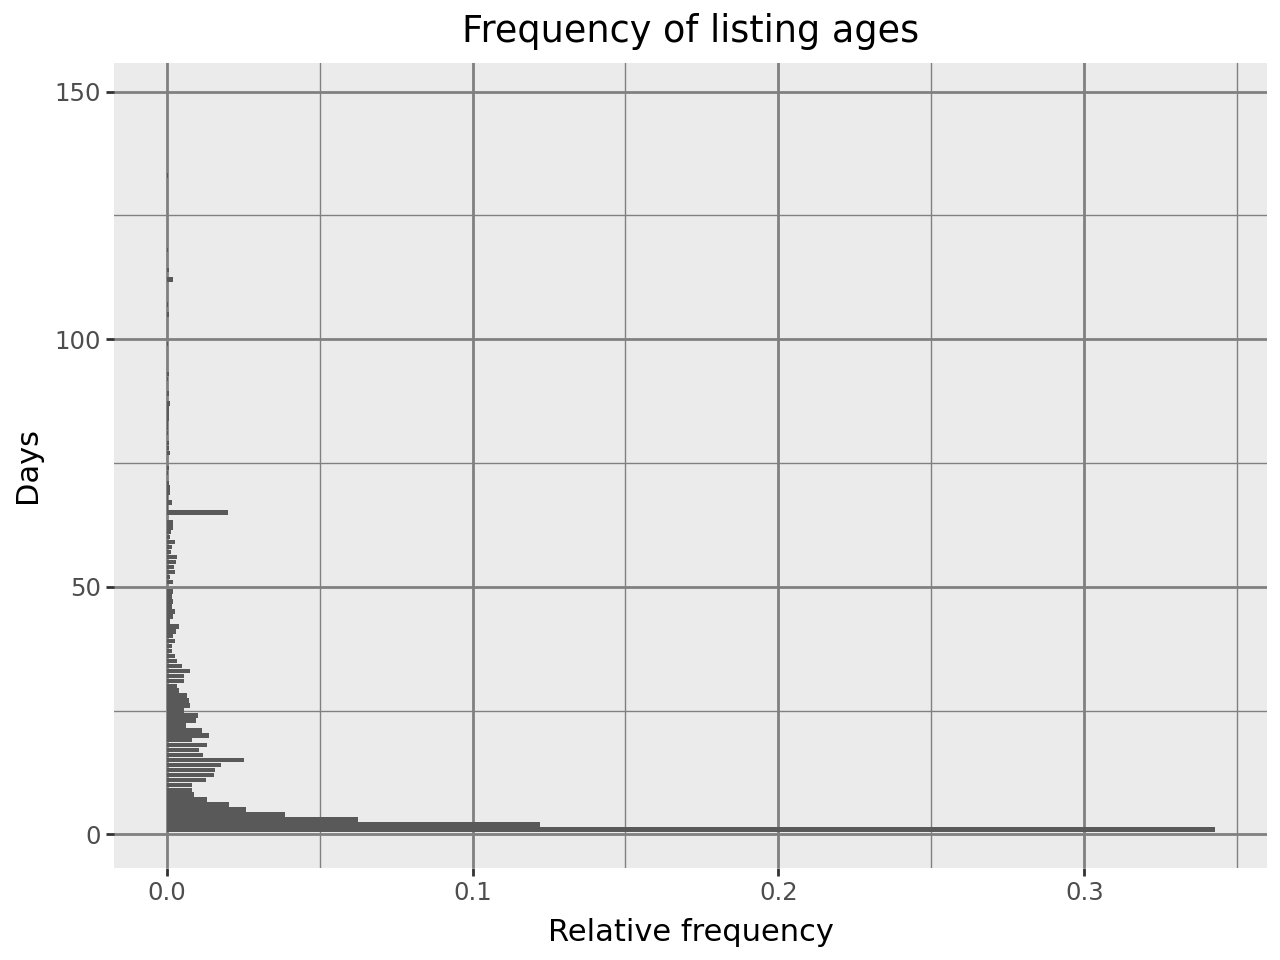

In [12]:
( p9.ggplot(
    data=df,
    mapping=p9.aes(x='length',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='Days',y='Relative frequency')
+ p9.coord_flip()
+ p9.ggtitle("Frequency of listing ages")
+ p9.theme(
    plot_background=p9.element_blank(),
    panel_grid_major=p9.element_line(color="gray"),
    panel_grid_minor=p9.element_line(color="gray")
    )
)

### What is the most popular weekday for posting new listings?

In [13]:
df['first_appeared'] = pd.to_datetime(df['first_appeared'])
df['last_appeared'] = pd.to_datetime(df['last_appeared'])
df['weekday_first']=df['first_appeared'].dt.day_name()
df['weekday_last']=df['last_appeared'].dt.day_name()
df

,company_name,job_name,domain,first_appeared,last_appeared,job_link,level,length,weekday_first,weekday_last
3038,lightyear,kyb compliance operations specialist,other,2024-04-02,2024-08-27,https://careers.lightyear.com/jobs/3624928-kyb...,mid/unknown,148,Tuesday,Tuesday
2389,bolt,"senior/staff ux researcher, ridehailing",other,2024-04-06,2024-08-21,https://careers.bolt.eu/positions/7314800002,senior,138,Saturday,Wednesday
18,artec design,linkedin,other,2024-04-02,2024-08-12,https://ee.linkedin.com/company/artec-design-ee,mid/unknown,133,Tuesday,Monday
15,artec design,facebook,other,2024-04-02,2024-08-12,https://www.facebook.com/artecdesign.ee/,mid/unknown,133,Tuesday,Monday
4234,wise,senior implementation manager - finance systems,finance,2024-04-27,2024-09-02,https://jobs.smartrecruiters.com/wise/74399998...,senior,129,Saturday,Monday
...,...,...,...,...,...,...,...,...,...,...
1194,bolt,senior bid writer,other,2024-06-19,2024-06-19,https://careers.bolt.eu/positions/7465472002,senior,1,Wednesday,Wednesday
1193,bolt,senior bid writer,other,2024-06-17,2024-06-17,https://careers.bolt.eu/positions/7465472002,senior,1,Monday,Monday
47,bankera,quality assurance specialist,other,2024-03-26,2024-03-26,https://careers.bankera.com/en/it/quality-assu...,mid/unknown,1,Tuesday,Tuesday
49,bankera,react front-end developer (mid/senior),other,2024-03-26,2024-03-26,https://careers.bankera.com/en/it/react-front-...,senior,1,Tuesday,Tuesday


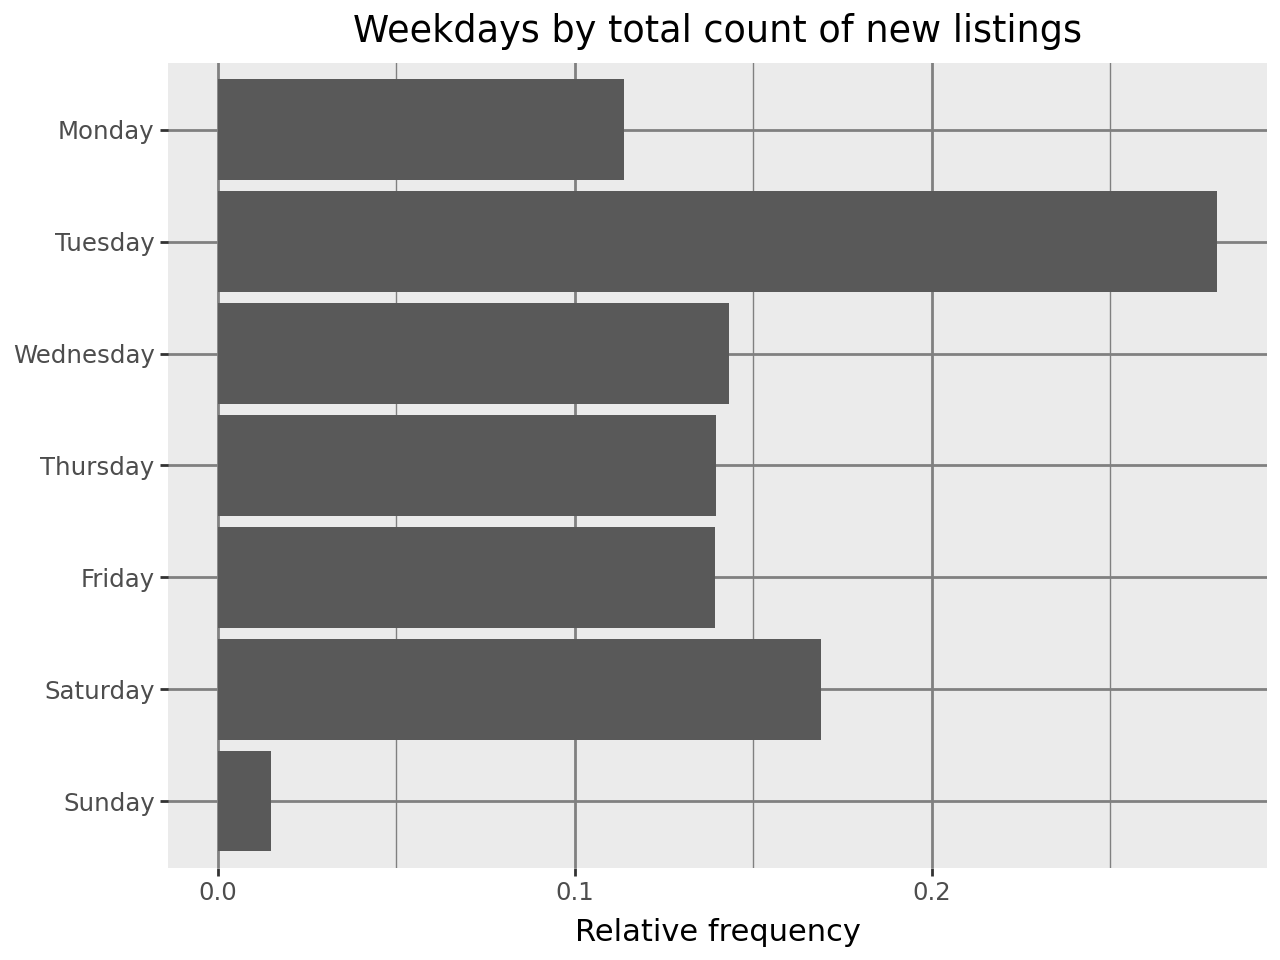

In [14]:
weekdays_sorted=['Sunday','Saturday','Friday','Thursday','Wednesday','Tuesday','Monday']
weekday_cat=pd.Categorical(df['weekday_first'], categories=weekdays_sorted)

( p9.ggplot(
    data=df,
    mapping=p9.aes(x='weekday_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
+ p9.ggtitle("Weekdays by total count of new listings")
+ p9.theme(
    plot_background=p9.element_blank(),
    panel_grid_major=p9.element_line(color="gray"),
    panel_grid_minor=p9.element_line(color="gray")
    )
)

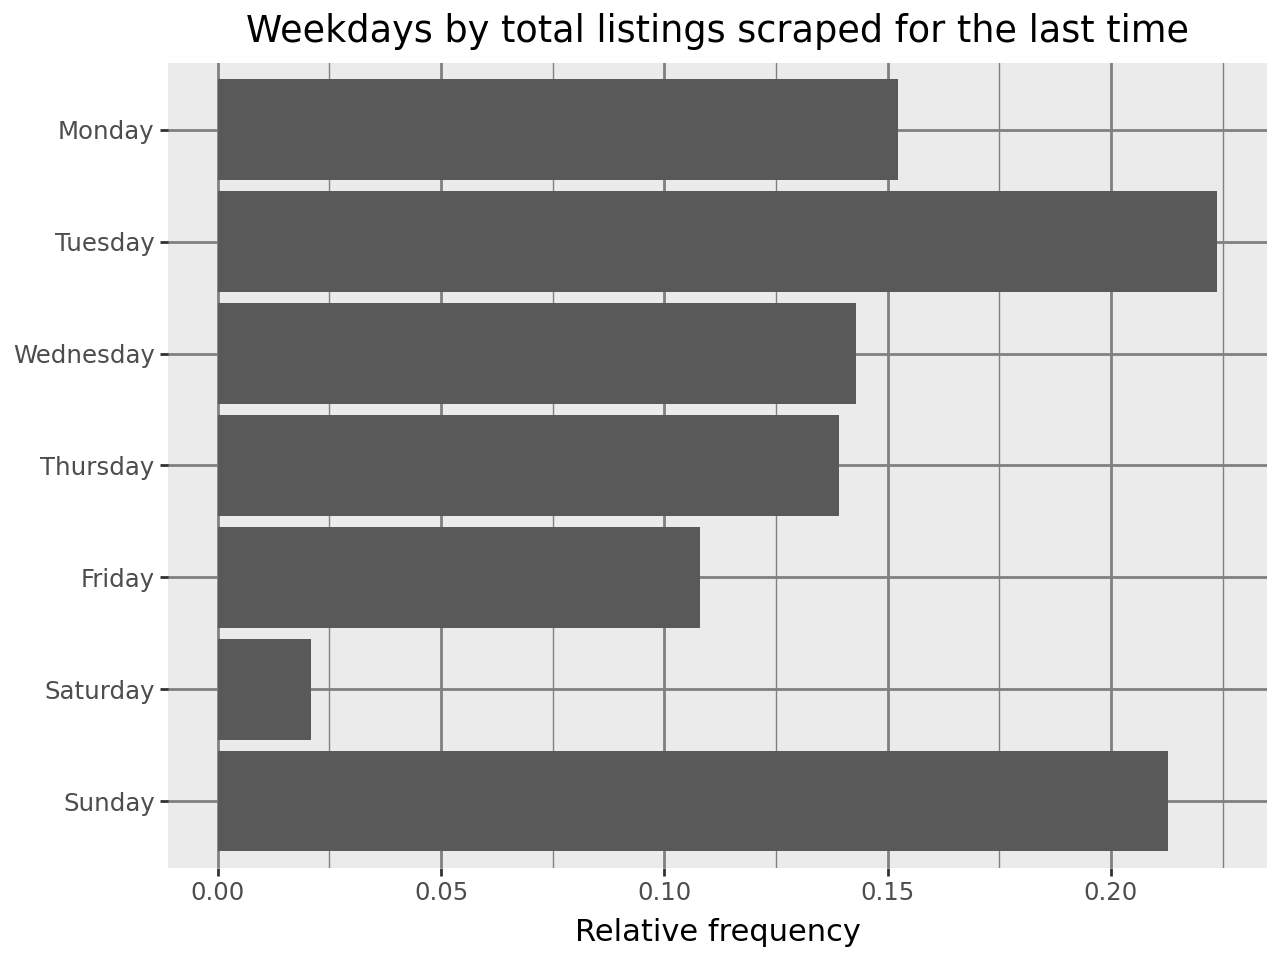

In [15]:
weekdays_sorted=['Sunday','Saturday','Friday','Thursday','Wednesday','Tuesday','Monday']
weekday_cat=pd.Categorical(df['weekday_last'], categories=weekdays_sorted)

( p9.ggplot(
    data=df,
    mapping=p9.aes(x='weekday_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
+ p9.ggtitle("Weekdays by total listings scraped for the last time")
+ p9.theme(
    plot_background=p9.element_blank(),
    panel_grid_major=p9.element_line(color="gray"),
    panel_grid_minor=p9.element_line(color="gray")
    )
)

# Amount of total listings by month

/home/mina/python/miniconda3/envs/IDS/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 45'. Pick better value with 'binwidth'.


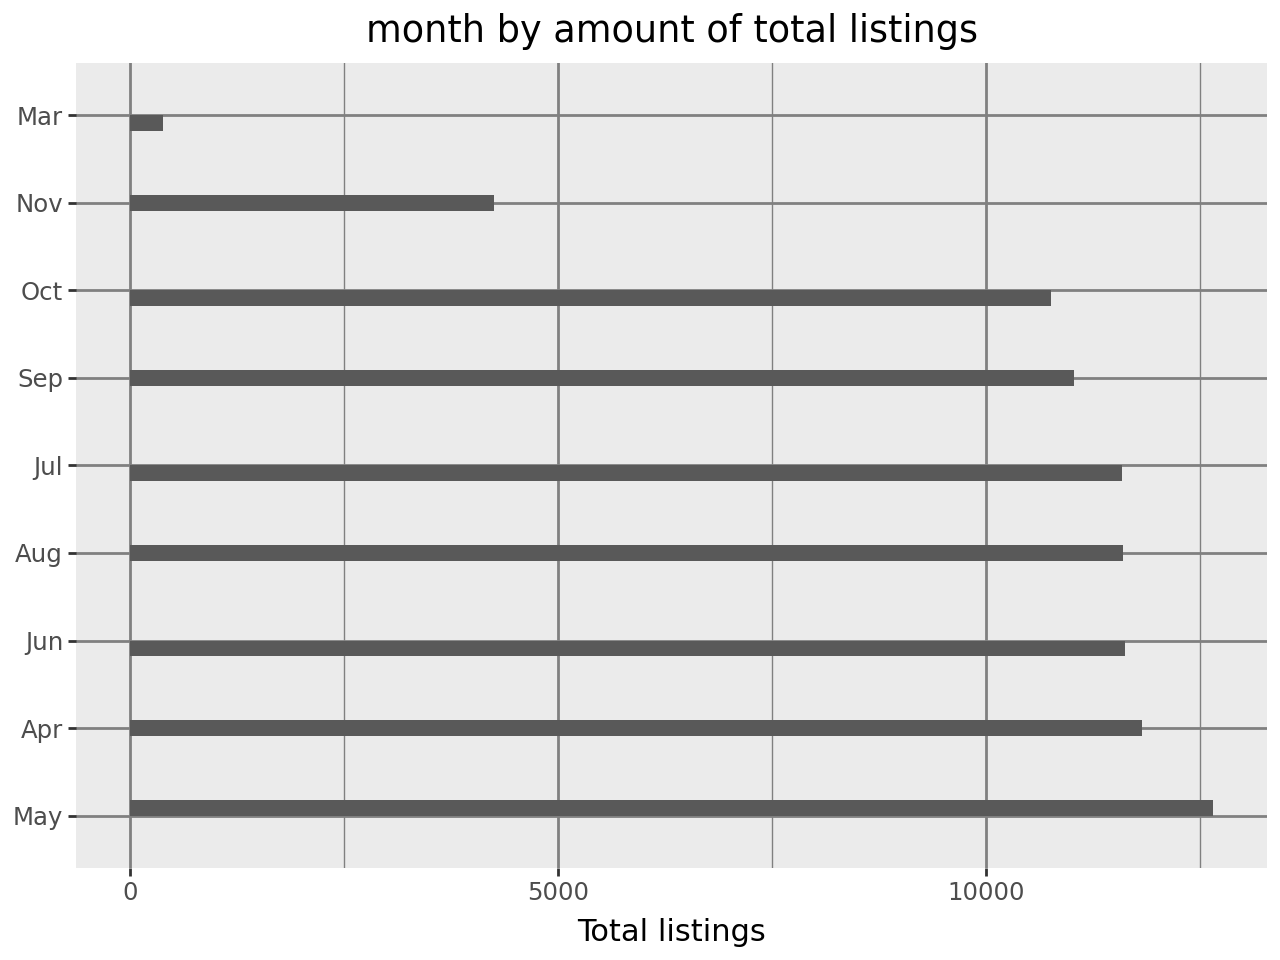

In [16]:
data['month']=data['date_added'].apply(lambda x: x.month)
data['month']=data['month'].apply(lambda x: ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][x-1])

months_sorted=data['month'].value_counts().index.tolist()
months_cat=pd.Categorical(data['month'], categories=months_sorted)

( p9.ggplot(
    data=data,
    mapping=p9.aes(x='months_cat')
)
+ p9.geom_histogram()
+ p9.labs(x='',y='Total listings')
+ p9.coord_flip()
+ p9.ggtitle("month by amount of total listings")
+ p9.theme(
    plot_background=p9.element_blank(),
    panel_grid_major=p9.element_line(color="gray"),
    panel_grid_minor=p9.element_line(color="gray")
    )
)

## Identify listings that get posted repeatedly
A listing being posted repeatedly (not being scraped for a while and then reappearing) could imply that a new hire has failed the probationary period and a new hire is needed.

Here we highlight repeating listings and classify them with the column `repeats`, which is `True` if the listing is found to repeat and `False` if not.

In [17]:
for name, group in df.groupby('job_link'):
  if len(group)>1:
    print(name)
    print(str(len(group))+' appearances')
    print(group)

df['repeats']=df['job_link'].duplicated()

https://apply.workable.com/j/1334e25a55
2 appearances
               company_name  \
3733  skeleton technologies   
3732  skeleton technologies   

                                               job_name domain first_appeared  \
3733  mechanical engineer energy storage systems (m/...  other     2024-04-02   
3732  mechanical engineer energy storage systems (m/...  other     2024-03-26   

     last_appeared                                 job_link        level  \
3733    2024-07-07  https://apply.workable.com/j/1334e25a55  mid/unknown   
3732    2024-03-26  https://apply.workable.com/j/1334e25a55  mid/unknown   

      length weekday_first weekday_last  
3733      97       Tuesday       Sunday  
3732       1       Tuesday      Tuesday  
https://apply.workable.com/j/1bf46b49bc
2 appearances
     company_name                              job_name domain first_appeared  \
2647   creditstar  senior product manager - investments  other     2024-04-02   
2646   creditstar  senior product man

     company_name                                           job_name domain  \
3415       pactum  operations support specialist - korean/japanes...  other   
3414       pactum  operations support specialist - korean/japanes...  other   

     first_appeared last_appeared  \
3415     2024-09-07    2024-11-10   
3414     2024-03-26    2024-03-26   

                                               job_link        level  length  \
3415  https://boards.eu.greenhouse.io/pactum/jobs/43...  mid/unknown      65   
3414  https://boards.eu.greenhouse.io/pactum/jobs/43...  mid/unknown       1   

     weekday_first weekday_last  
3415      Saturday       Sunday  
3414       Tuesday      Tuesday  
https://boards.eu.greenhouse.io/pactum/jobs/4308428101
3 appearances
     company_name                                     job_name domain  \
3405       pactum  implementation specialist (german speaking)  other   
3404       pactum                    implementation specialist  other   
3403       pactum  

# What domains are the most popular?

Sort by domain, report frequency

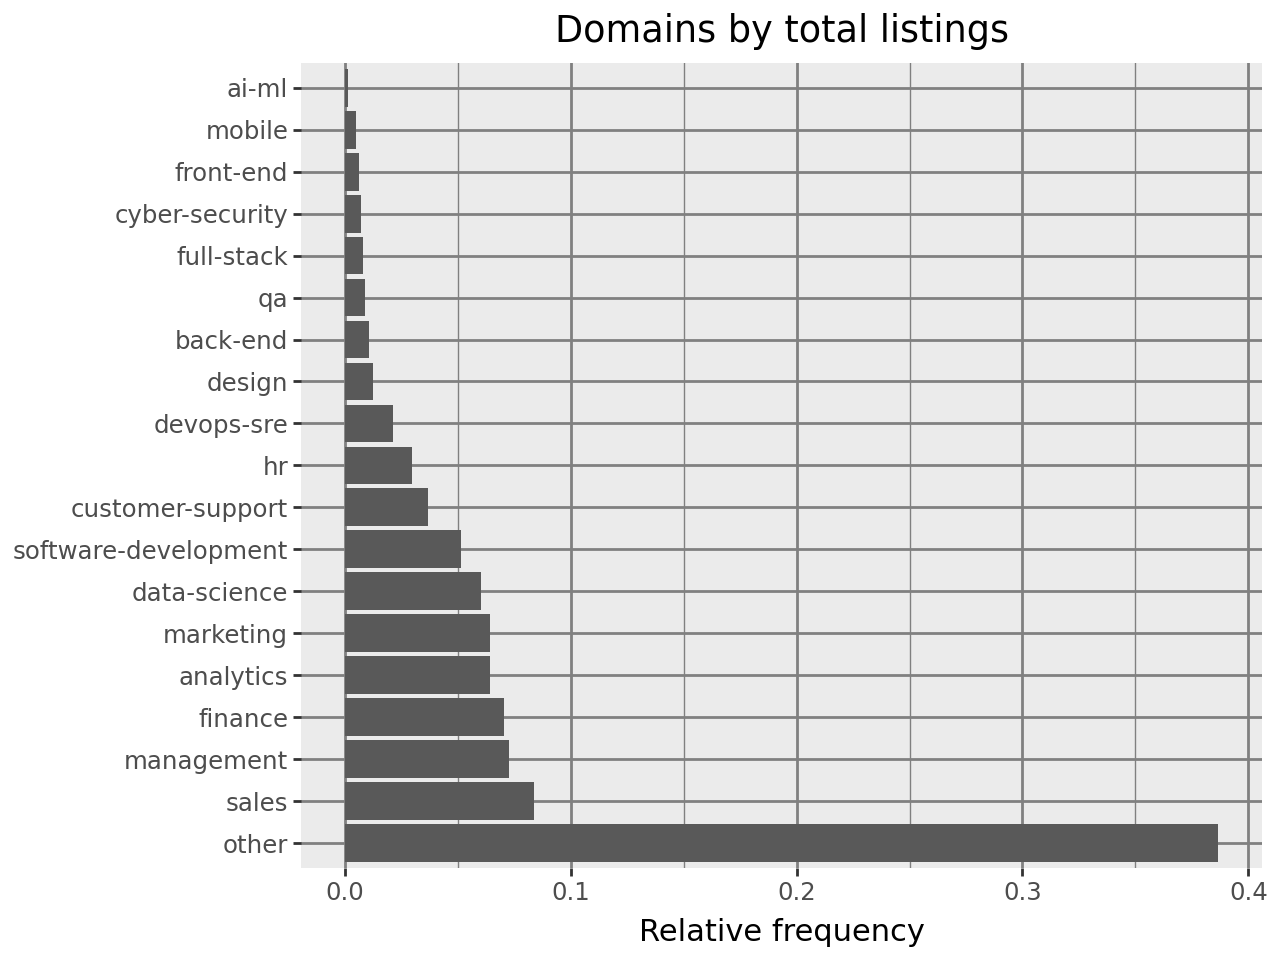

In [18]:
domains_sorted=df['domain'].value_counts().index.tolist()
domain_cat=pd.Categorical(df['domain'], categories=domains_sorted)

( p9.ggplot(
    data=df,
    mapping=p9.aes(x='domain_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
+ p9.ggtitle("Domains by total listings")
+ p9.theme(
    plot_background=p9.element_blank(),
    panel_grid_major=p9.element_line(color="gray"),
    panel_grid_minor=p9.element_line(color="gray")
    )
)

# Who are the biggest hirerers?

In [19]:
df["company_name"].value_counts()

company_name
bolt             2399
wise              309
luminor           254
seb               154
yolo group        147
                 ... 
textmagic           3
change invest       2
coursy              2
jobbatical          2
boku                1
Name: count, Length: 73, dtype: int64

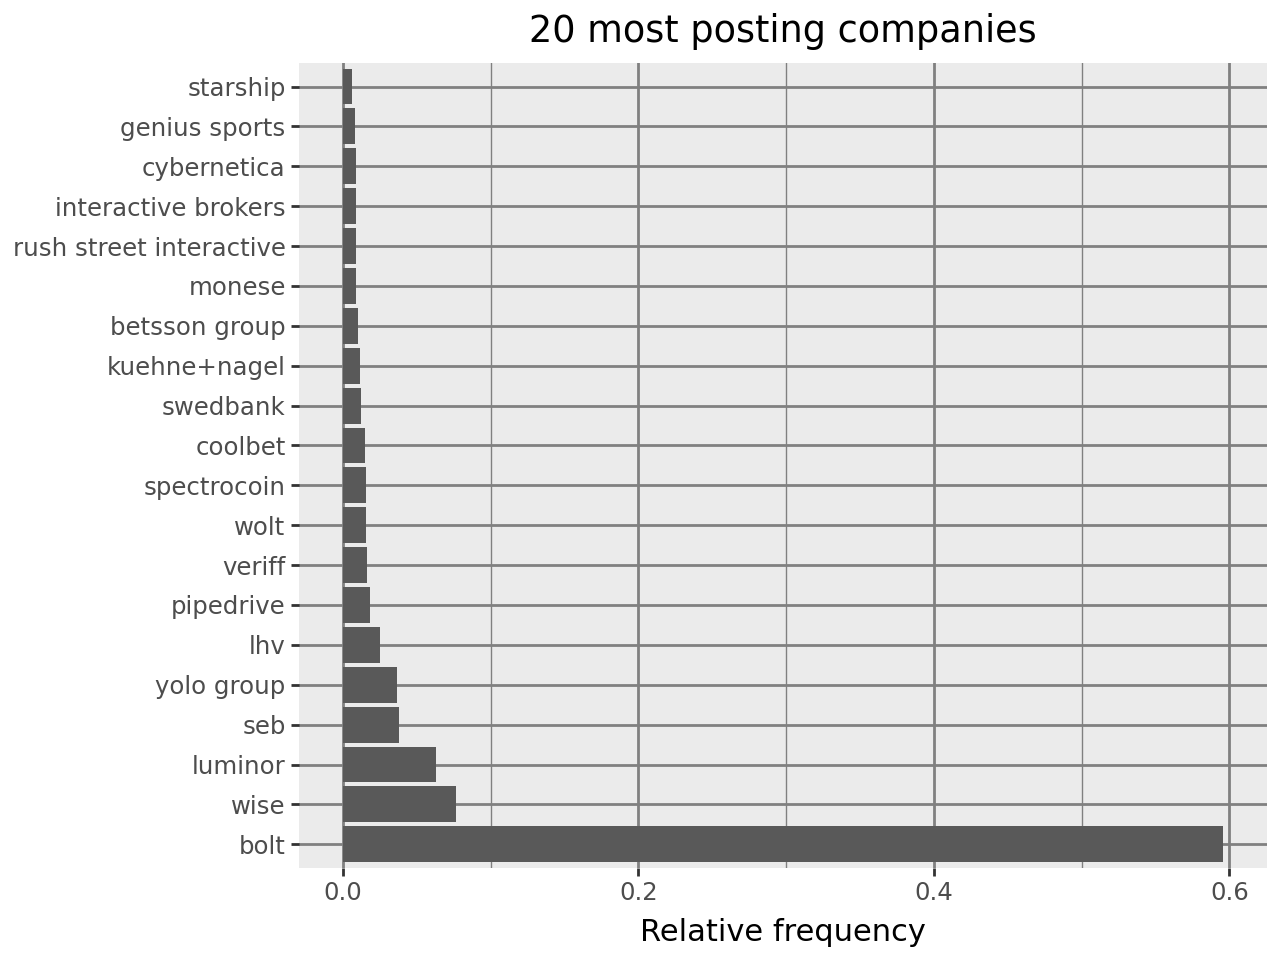

In [20]:
company_name_sorted=df['company_name'].value_counts().index.tolist()[:20]
df_top = df[df['company_name'].isin(company_name_sorted)]
domain_cat=pd.Categorical(df_top['company_name'], categories=company_name_sorted)

( p9.ggplot(
    data=df_top,
    mapping=p9.aes(x='domain_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
+ p9.ggtitle("20 most posting companies")
+ p9.theme(
    plot_background=p9.element_blank(),
    panel_grid_major=p9.element_line(color="gray"),
    panel_grid_minor=p9.element_line(color="gray")
    )
)

# Analisyng listings by level

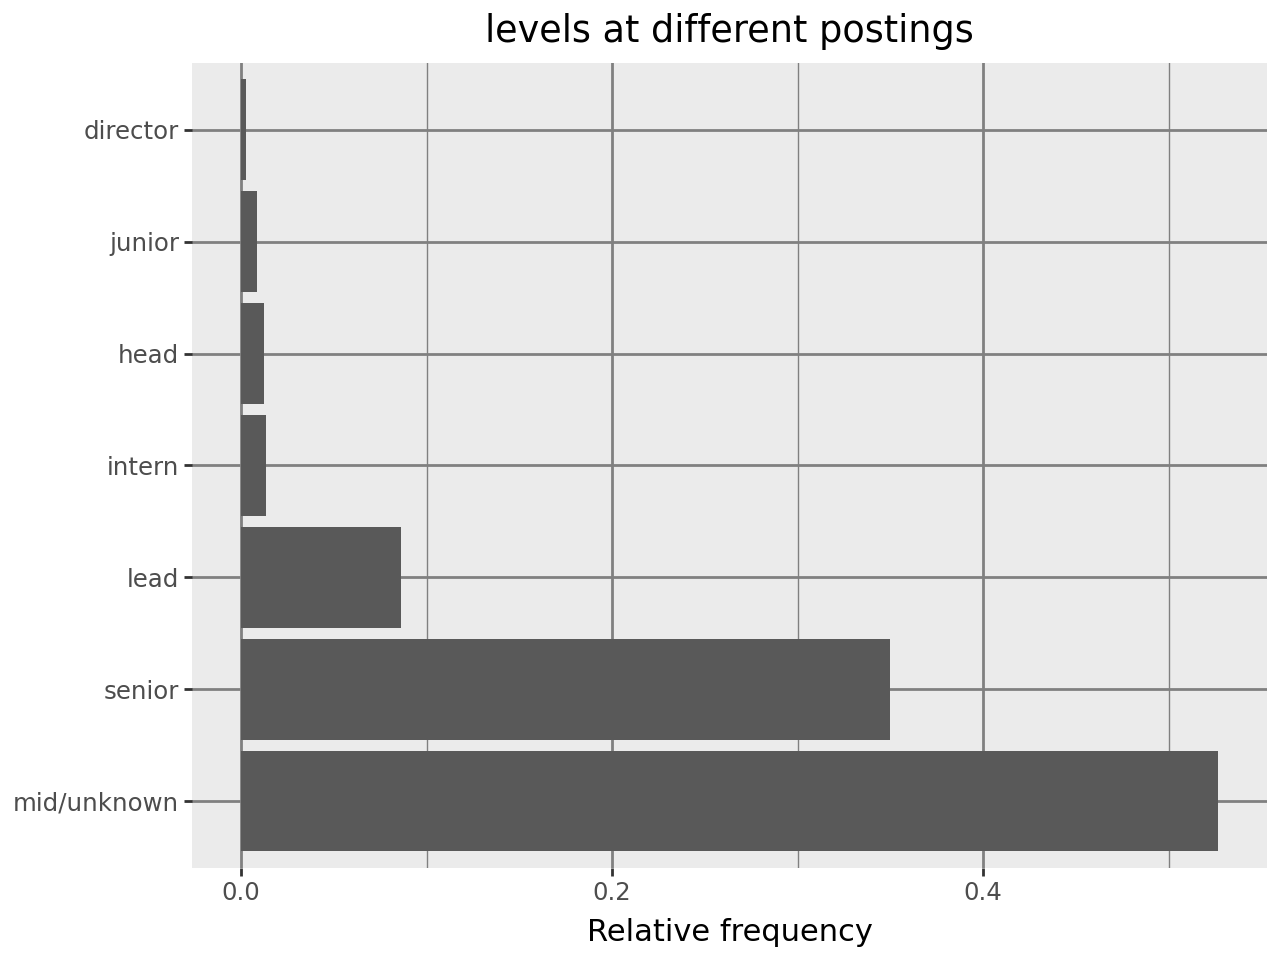

In [21]:
levels_sorted=df['level'].value_counts().index.tolist()
levels_cat=pd.Categorical(df['level'], categories=levels_sorted)

( p9.ggplot(
    data=df,
    mapping=p9.aes(x='levels_cat',y=p9.after_stat('count / np.sum(count)'))
)
+ p9.geom_bar()
+ p9.labs(x='',y='Relative frequency')
+ p9.coord_flip()
+ p9.ggtitle("levels at different postings")
+ p9.theme(
    plot_background=p9.element_blank(),
    panel_grid_major=p9.element_line(color="gray"),
    panel_grid_minor=p9.element_line(color="gray")
    )
)

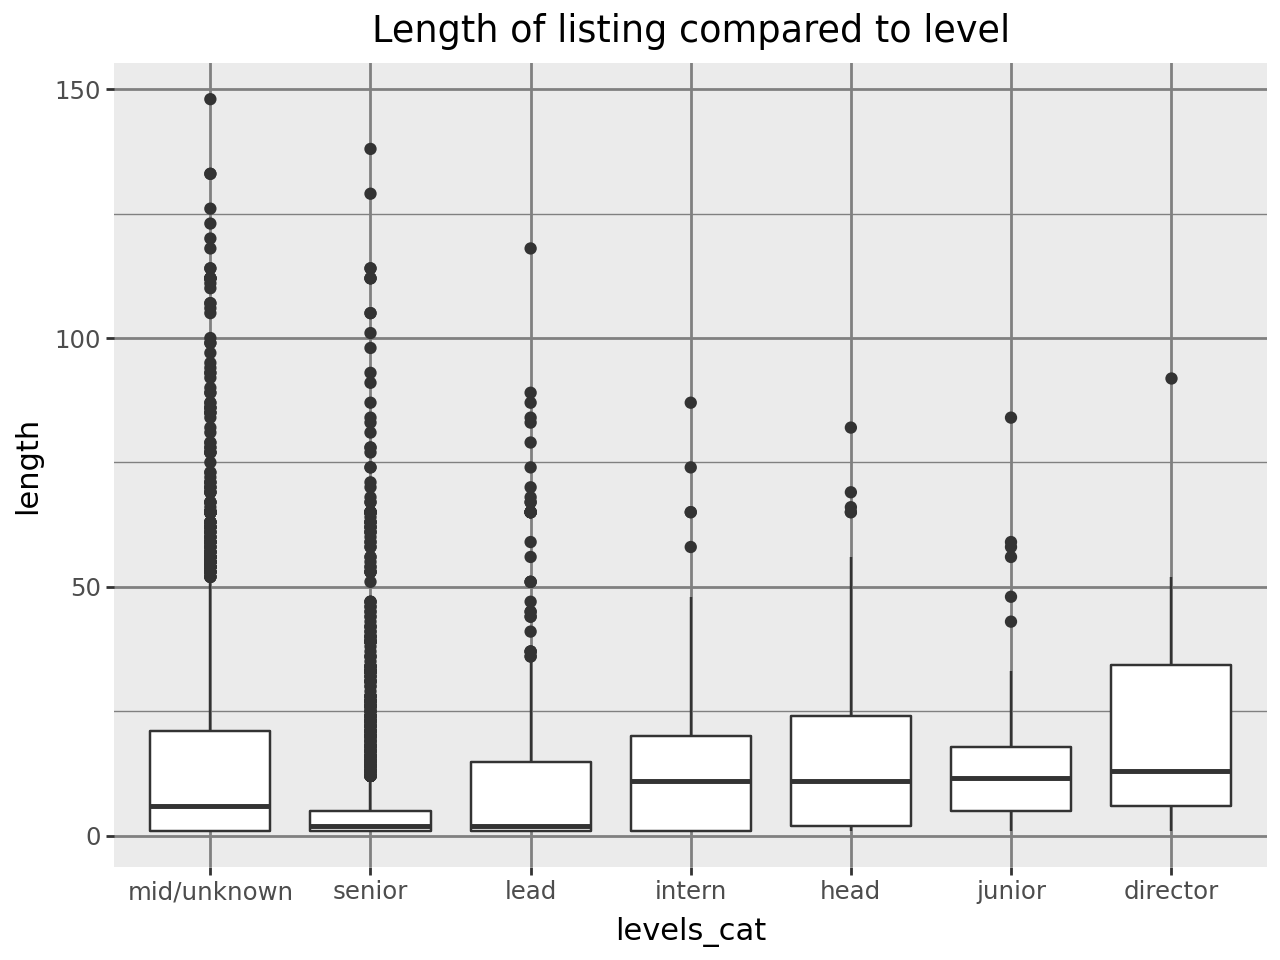

In [22]:
( p9.ggplot(
    data=df,
    mapping=p9.aes(x='levels_cat',y='length')
)
+ p9.geom_boxplot()
+ p9.ggtitle("Length of listing compared to level")
+ p9.theme(
   plot_background=p9.element_blank(),
   panel_grid_major=p9.element_line(color="gray"),
   panel_grid_minor=p9.element_line(color="gray")
    )
)

/home/mina/python/miniconda3/envs/IDS/lib/python3.12/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 927 rows containing non-finite values.


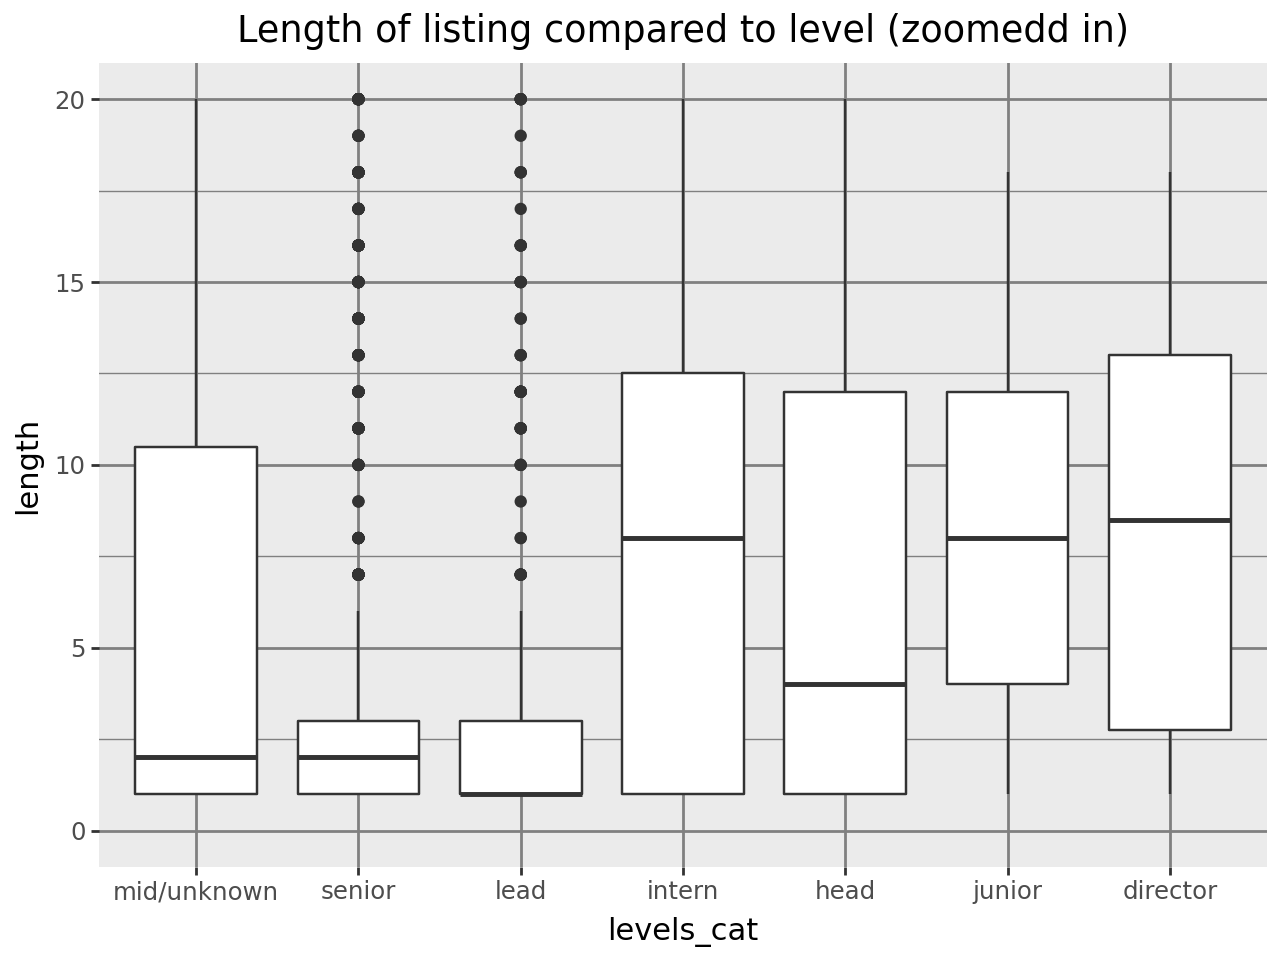

In [23]:
( p9.ggplot(
    data=df,
    mapping=p9.aes(x='levels_cat',y='length')
)
+ p9.geom_boxplot()
+ p9.ggtitle("Length of listing compared to level (zoomedd in)")
+ p9.theme(
   plot_background=p9.element_blank(),
   panel_grid_major=p9.element_line(color="gray"),
   panel_grid_minor=p9.element_line(color="gray")
    )
  + p9.scale_y_continuous(limits=(0, 20))
)

# Frequent pattern mining

Since the dataset contains transactions with different discrete categorical values, it is better suited for analysis with frequent pattern mining.

In [24]:
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori

#one-hot encoding
onehot_df = pd.get_dummies(df, columns = ['company_name', 'job_name', 'domain', 'weekday_first','weekday_last', 'level']).drop(columns=['first_appeared','last_appeared','job_link','length'],axis=1)
#mine association rules
freq_itemsets = apriori(onehot_df, min_support=5/len(onehot_df), use_colnames=True)
rules_df=association_rules(freq_itemsets,metric='confidence',min_threshold=0.5)

rules_df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(company_name_bankera),(repeats),0.004410,0.555017,0.002205,0.500000,0.900874,-0.000243,0.889967,-0.099521
1,(company_name_bolt),(repeats),0.528997,0.555017,0.448071,0.847020,1.526116,0.154469,2.908761,0.731931
2,(repeats),(company_name_bolt),0.555017,0.528997,0.448071,0.807310,1.526116,0.154469,2.444361,0.774729
3,(company_name_novater solutions),(repeats),0.002646,0.555017,0.001764,0.666667,1.201165,0.000295,1.334950,0.167920
4,"(job_name_analytics manager, growth and financ...",(repeats),0.011687,0.555017,0.011246,0.962264,1.733758,0.004759,11.792062,0.428223
...,...,...,...,...,...,...,...,...,...,...
56246,"(weekday_first_Thursday, company_name_bolt, jo...","(level_mid/unknown, domain_data-science, weekd...",0.001323,0.003087,0.001103,0.833333,269.940476,0.001098,5.981477,0.997615
56247,"(weekday_last_Thursday, company_name_bolt, job...","(level_mid/unknown, domain_data-science, weekd...",0.001323,0.002646,0.001103,0.833333,314.930556,0.001099,5.984123,0.998145
56248,"(weekday_last_Thursday, weekday_first_Thursday...","(level_mid/unknown, domain_data-science, compa...",0.001103,0.015215,0.001103,1.000000,65.724638,0.001086,inf,0.985872
56249,"(weekday_first_Thursday, job_name_staff data s...","(level_mid/unknown, repeats, domain_data-scien...",0.001323,0.003087,0.001103,0.833333,269.940476,0.001098,5.981477,0.997615
